In [53]:
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import numpy as np
import pandas as pd
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50

In [54]:
img_height = 256
img_width = 256
channels = 3
batch_size = 16
epochs = 20

In [55]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_set = train_datagen.flow_from_directory(
    './test',
    target_size = (img_height, img_width),
    
    batch_size = batch_size,
    class_mode = 'categorical',
    subset='training',
    shuffle=True)
val_set = train_datagen.flow_from_directory(
    './test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical', 
    subset='validation',
    shuffle=True)


Found 32 images belonging to 4 classes.
Found 8 images belonging to 4 classes.


In [56]:
num_class = train_set.num_classes
labels = train_set.class_indices.keys()
print(labels)

dict_keys(['COVID-19', 'NORMAL', 'PNEUMONIA', 'TBC'])


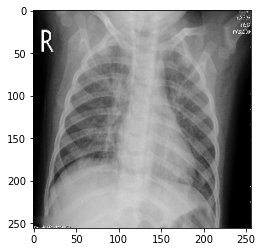

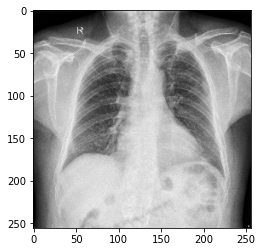

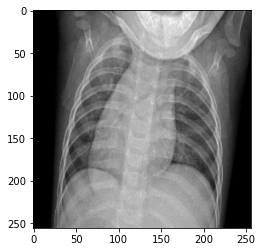

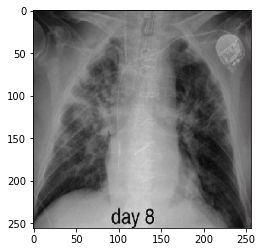

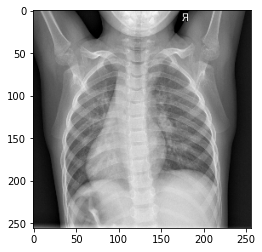

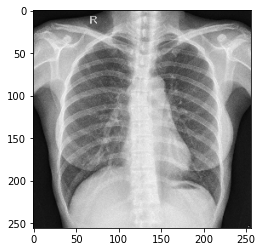

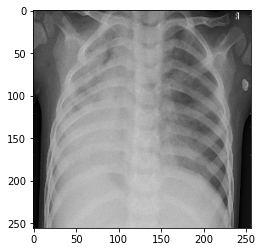

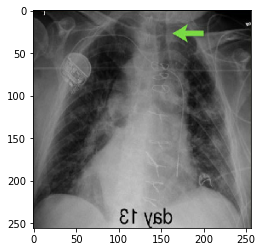

In [57]:
x,y = val_set.next()
for i in range(8):
    image = x[i]
    plt.imshow(image)
    plt.show()

In [65]:
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.models import Model
model = VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, channels))

for layer in model.layers:
    layer.trainable = False

headModel = model.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(num_class, activation="softmax")(headModel)
model = Model(inputs=model.input, outputs=headModel)
print(model.summary())

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

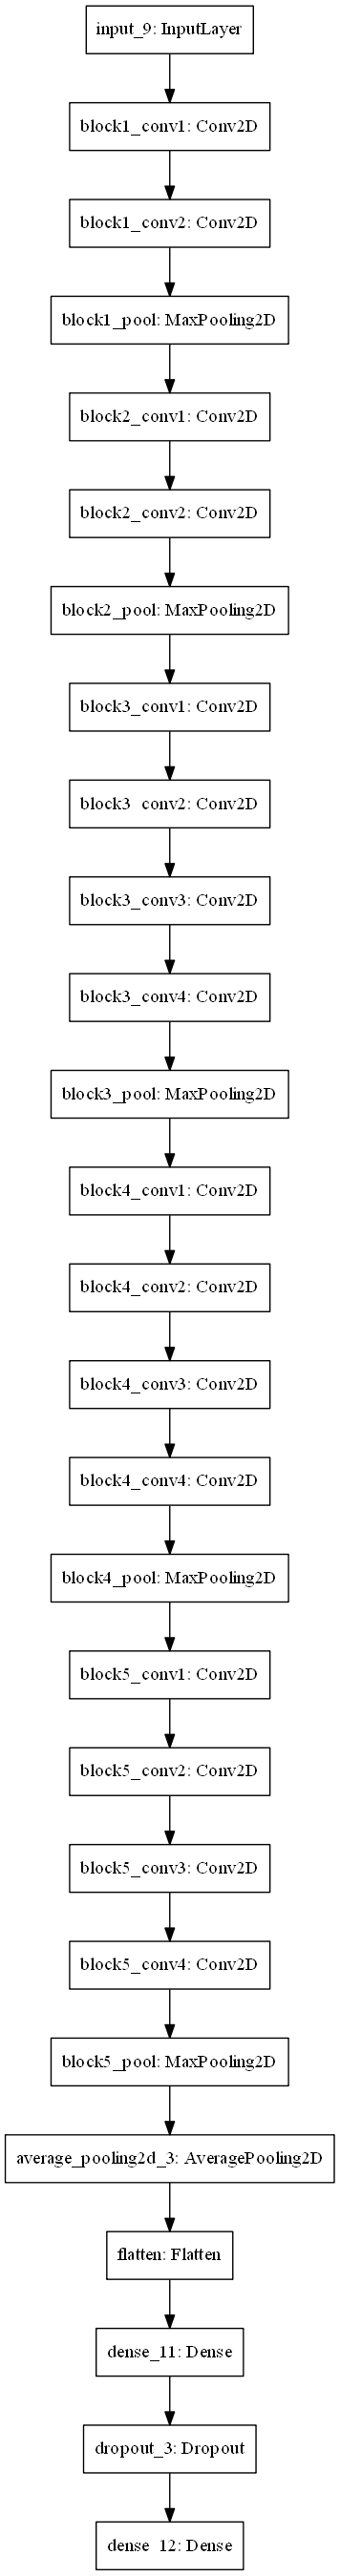

In [66]:
from keras.utils.vis_utils import plot_model
model_viz = tf.keras.utils.plot_model(model,
                          to_file='modelvgg19.png',
                          show_shapes=False,
                          show_layer_names=True,
                          rankdir='TB',
                          expand_nested=True,
                          dpi=100)
model_viz

In [67]:
model.compile(loss='categorical_crossentropy',
                  optimizer='RMSprop',
                  metrics=['accuracy'])
%matplotlib inline
import math 
import datetime
import time

In [69]:
start = datetime.datetime.now()
history_tl = model.fit_generator(train_set,
                                 steps_per_epoch=train_set.n // 16,
                                 epochs=5,
                                 validation_data=val_set,
                                 validation_steps=val_set.n // 16)
end= datetime.datetime.now()
elapsed= end-start
print ('Waktu: ', elapsed)
plt.plot(history_tl.history['loss'], label='train loss')
plt.plot(history_tl.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('loss_vgg195')
# plot the accuracy
plt.plot(history_tl.history['accuracy'], label='train acc')
plt.plot(history_tl.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('acc_vgg195')
model.save('TEST.h5')
test_score = model.evaluate_generator(train_set, batch_size)
print('Akurasi',test_score[1]) 
print('Loss',test_score[0])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2 steps, validate for 1 steps
Epoch 1/5
2/2 [==============================] - 645s 322s/step - loss: 1.4344 - accuracy: 0.3438 - val_loss: 1.3066 - val_accuracy: 0.5000
Epoch 2/5
1/2 [==============>...............] - ETA: 4:43

KeyboardInterrupt: 

In [10]:
test_score = model.evaluate_generator(val_set, 32)
print('Akurasi',test_score[1],'%') 
print('Loss',test_score[0],'%')

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
Akurasi 0.27734375 %
Loss 1.467111311852932 %


In [11]:
from sklearn.metrics import classification_report, confusion_matrix
model = tf.keras.models.load_model('RESNETepoch5-80%.h5')
Y_pred = model.predict(val_set)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(val_set.classes, y_pred))
print('Classification Report')
print(classification_report(val_set.classes, y_pred, target_names=labels))

Found 40 images belonging to 4 classes.
Confusion Matrix
Found 40 images belonging to 4 classes.


TypeError: confusion_matrix() got an unexpected keyword argument 'target_names'

In [6]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Found 40 images belonging to 4 classes.
Confusion Matrix
Confusion matrix, without normalization
Classification Report
              precision    recall  f1-score   support

    COVID-19       1.00      1.00      1.00        10
      NORMAL       1.00      0.80      0.89        10
   PNEUMONIA       0.83      1.00      0.91        10
         TBC       1.00      1.00      1.00        10

    accuracy                           0.95        40
   macro avg       0.96      0.95      0.95        40
weighted avg       0.96      0.95      0.95        40



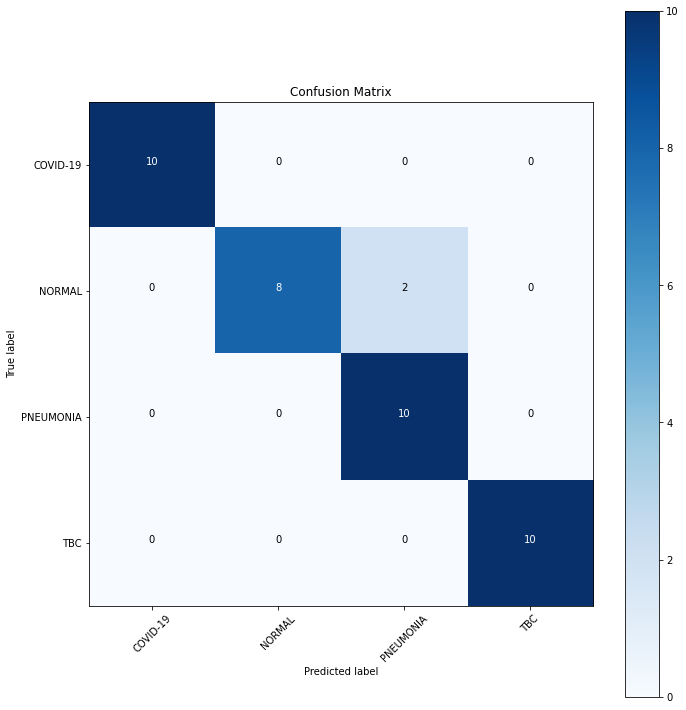

In [7]:
test_datagen = ImageDataGenerator(rescale=1. / 255,
                                  )
test_generator = test_datagen.flow_from_directory( './test',
                                                    target_size = (img_height, img_width),
                                                    batch_size=5,
                                                    class_mode='categorical', shuffle=False)
model = tf.keras.models.load_model('VGG19-80%-100.h5')
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, labels, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=labels))

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory( './test',
                                                    target_size = (img_height, img_width),
                                                    batch_size=5,
                                                    class_mode='categorical', shuffle=False)
model = tf.keras.models.load_model('RESNET-20%-50.h5')
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)


df = pd.DataFrame(data, columns=[test_generator.classes,y_pred])
confusion_matrix = pd.crosstab(df[test_generator], df[y_pred], rownames=['Actual'], colnames=['Predicted'], margins = True)

sn.heatmap(confusion_matrix, annot=True)
plt.show()

Found 40 images belonging to 4 classes.


In [10]:
from keras.models import load_model
from keras.preprocessing import image
from keras  import preprocessing
model = tf.keras.models.load_model('VGG19-80%-100.h5')

result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1])

  ...
    to  
  ['...']
8/8 [==============================] - 769s 96s/step - loss: 0.3302 - accuracy: 0.9500
Loss: 0.3301714440531214
Accuracy: 0.95


In [ ]:
from tensorflow import GradientTape
with tf.GradientTape() as tape:
    last_conv_layer = model.get_layer('block5_conv4')
    iterate=Model([model.inputs],[model.output,last_conv_layer.output])
    model_out,last_conv_layer=iterate(x)
    class_out=model_out[:,np.argmax(model_out[0])]
    grads=tape.gradient(class_out,last_conv_layer)
    pooled_grads=K.mean(grads,axis=(0,1,2))
    heatmap=tf.reduce_mean(tf.multiply(pooled_grads,last_conv_layer),axis=-1)

In [ ]:
image_path="dataset/train/normal/IM-0115-0001.jpeg"
img = cv2.imread(image_path)
INTENSITY=0.5
img1=img.shape[1]
img0=img.shape[0]
heatmap=cv2.resize(heatmap, (img0, img1))
heatmap=cv2.applyColorMap(np.uint8(255*heatmap),cv2.COLORMAP_JET)
img= heatmap * INTENSITY + img

imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
y = model.predict(img_data)
print('Kategori :',labels[np.argmax(y)])
print('Akurasi  :', 100*np.max(y),'%')